# Extract GPS data from dashcam footage
gps_bend_finding_with_gaussian_smoothing_and_DBSCAN_clustering

In [126]:
ids = [10]
# 10

min_string_length = 9
DATASET_PATH = "/home/aap9002/Stereo-Road-Curvature-Dashcam"


In [127]:
import re
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [128]:
def count_frames(video_path:str):
    """Count the number of frames in the video

    Args:
        video_path (str): The path to the video

    Returns:
        int: The number of frames in the video
    """
    
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return length

def get_file_and_output_folder(id:int):
    """Get the file path and output folder for the given id

    Args:
        id (int): The id of the video

    Returns:
        tuple[str, str]: The file path and the output_folder
    """
    
    file_path = f"{DATASET_PATH}/day/{id:03d}/R.MP4"
    output_folder = f"{DATASET_PATH}/day/{id:03d}/bends"

    if not os.path.exists(file_path):
        raise FileNotFoundError(f'File {file_path} not found')
    
    print(f'Processing video {id:03d} with {count_frames(file_path)} frames')
    os.makedirs(output_folder, exist_ok=True)
    print(f'Results will be saved in {output_folder}')
    return file_path, output_folder

def time_stamp_to_epoch(time_stamp:str):
    """Convert a time stamp to epoch time

    Args:
        time_stamp (str): The time stamp in the format HHMMSS:sss

    Returns:
        int: The epoch time
    """
    
    hours = int(time_stamp[:2])
    minutes = int(time_stamp[2:4])
    seconds = int(time_stamp[4:6])
    milliseconds = int(time_stamp[7:])

    return (hours*60*60 + minutes*60 + seconds)*1000 + milliseconds

# Lat and Long to X and Y

In [129]:
def lat_lon_to_x_y(lat:float, lon:float, height:float = 0):
    """Convert latitude, longitude and height to x, y and z

    Args:
        lat (float): latitude
        lon (float): longitude
        height (float): height above sea level
    """
    a = 6378137.0 # equatorial radius
    f = 0.003352810681183637418 # flattening

    e2 = f*(2-f) # first eccentricity squared

    Rn = a / np.sqrt(1 - e2*np.sin(lat)**2) # radius of curvature in the prime vertical

    lat = np.radians(lat)
    lon = np.radians(lon)

    # calculate x, y, z
    x = (Rn + height) * np.cos(lat) * np.cos(lon)
    y = (Rn + height) * np.cos(lat) * np.sin(lon)
    z = (Rn*(1-e2) + height) * np.sin(lat)

    return x, y, z

In [130]:
file_path, output_folder = get_file_and_output_folder(ids[0])

Processing video 010 with 5400 frames
Results will be saved in /home/aap9002/Stereo-Road-Curvature-Dashcam/day/010/bends


In [131]:
!firefox {file_path} # display the video

Gtk-Message: 23:28:09.142: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
[86339, Main Thread] WARNING: GTK+ module /snap/firefox/5647/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.: 'glib warning', file /build/firefox/parts/firefox/build/toolkit/xre/nsSigHandlers.cpp:201

(firefox:86339): Gtk-WARNING **: 23:28:09.219: GTK+ module /snap/firefox/5647/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 23:28:09.219: Failed to load module "canberra-gtk-module"
[86339, Main Thread] WARNING: GTK+ module /snap/firefox/5647/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process

# Read file contents

In [132]:
def getNMEAStringsFromFile(file_path:str):
    """Get the NMEA strings from the file

    Args:
        file_path (str): The path to the file

    Returns:
        List[str]: The GPRMC|GPGGA strings from the file
    """
    strings = ""
    with open(file_path, "rb") as f:
        strings = f.read()

    pattern =  rb'\$(?:GPRMC|GPGGA)[ -~]{' + str(min_string_length).encode() + rb',}'
    strings = re.findall(pattern, strings)    
    return [s.decode('utf-8', errors='ignore') for s in strings]

In [133]:
data = getNMEAStringsFromFile(file_path)
frame_count = count_frames(file_path)
print(f'Found {len(data)} strings, of which {frame_count} frames are available')
data[:10]

Found 4088 strings, of which 5400 frames are available


['$GPRMC,144448.300,A,5305.23727,N,00226.77157,W,0.000,242.46,151124,,,A*59',
 '$GPGGA,144448.300,5305.23727,N,00226.77157,W,1,13,0.81,50.4,M,49.8,M,,*50',
 '$GPRMC,144448.400,A,5305.23727,N,00226.77157,W,0.000,242.46,151124,,,A*5E',
 '$GPGGA,144448.400,5305.23727,N,00226.77157,W,1,13,0.81,50.4,M,49.8,M,,*57',
 '$GPRMC,144448.500,A,5305.23727,N,00226.77157,W,0.000,242.46,151124,,,A*5F',
 '$GPGGA,144448.500,5305.23727,N,00226.77157,W,1,13,0.81,50.4,M,49.8,M,,*56',
 '$GPRMC,144448.600,A,5305.23727,N,00226.77158,W,0.000,242.46,151124,,,A*53',
 '$GPGGA,144448.600,5305.23727,N,00226.77158,W,1,13,0.81,50.4,M,49.8,M,,*5A',
 '$GPRMC,144448.700,A,5305.23728,N,00226.77158,W,0.000,242.46,151124,,,A*5D',
 '$GPGGA,144448.700,5305.23728,N,00226.77158,W,1,13,0.81,50.4,M,49.8,M,,*54']

In [134]:
def knots_to_mph(knots:float):
    """Convert knots to miles per hour

    Args:
        knots (float): The speed in knots

    Returns:
        float: The speed in miles per hour
    """
    return knots * 1.15078

def parse_gprmc(input_sequence:str):
    """Parse the GPRMC and GPGGA string and extract the latitude, longitude, height and speed

    Args:
        input_sequence (str[]): [GPRMC string, GPGGA string]

    Returns:
        dict: The extracted values as a dictionary
    """
    # $GPRMC,<time>,<status>,<latitude>,<N/S>,<longitude>,<E/W>,<speed>,<course>,<date>,<magnetic variation>,<E/W>,<checksum>
    parts_GPRMC = input_sequence[0].split(',')
    if len(parts_GPRMC) < 10 or parts_GPRMC[0] != '$GPRMC':
        # print(f'Invalid GPRMC string: {input_sequence}')
        return None
    
    # $GPGGA,<time>,<latitude>,<N/S>,<longitude>,<E/W>,<quality>,<satellites>,<HDOP>,<height>,<height unit>,<geoid separation>,<geoid separation unit>,<age of differential data>,<station ID>,<checksum>
    parts_GPGGA = input_sequence[1].split(',')
    if len(parts_GPGGA) < 10 or parts_GPGGA[0] != '$GPGGA':
        # print(f'Invalid GPGGA string: {input_sequence}')
        return None

    
    # Extract latitude and longitude with direction
    time = parts_GPRMC[1]
    valid = parts_GPRMC[2]  # A - data valid, V - data invalid
    latitude = parts_GPRMC[3]
    lat_direction = parts_GPRMC[4]
    longitude = parts_GPRMC[5]
    lon_direction = parts_GPRMC[6]
    height = parts_GPGGA[9]  # Height above sea level
    speed = parts_GPRMC[7]  # Speed in knots

    speed = knots_to_mph(float(speed))  # Convert speed to mph
    
    # Return the extracted values as a dictionary
    return {
        "time": time,
        "valid": True if valid == 'A' else False,
        "latitude": latitude + ' ' + lat_direction,
        "longitude": longitude + ' ' + lon_direction,
        "height": height,
        "speed": speed
    }

In [135]:
positions = []
for i in range(0, len(data), 2):
    lat_lon = parse_gprmc(data[i:i+2])
    if lat_lon:
        positions.append(lat_lon)

print(f"Found {len(positions)} positions")
print("valid positions:", len([p for p in positions if p['valid']]))
print("invalid positions:", len([p for p in positions if not p['valid']]))

STARTING_TIME = time_stamp_to_epoch(positions[0]['time'])
print(f"Starting time: {STARTING_TIME}")

END_TIME = time_stamp_to_epoch(positions[-1]['time'])
print(f"Ending time: {END_TIME}")

# remove records with the same values
positions = [dict(t) for t in {tuple(d.items()) for d in positions}]
print(f"Unique positions: {len(positions)}")



positions[:2]


Found 2044 positions
valid positions: 2044
invalid positions: 0
Starting time: 53088300
Ending time: 53268000
Unique positions: 1864


[{'time': '144734.000',
  'valid': True,
  'latitude': '5304.72622 N',
  'longitude': '00227.85489 W',
  'height': '35.4',
  'speed': 32.43358352},
 {'time': '144708.100',
  'valid': True,
  'latitude': '5304.84050 N',
  'longitude': '00227.60265 W',
  'height': '49.8',
  'speed': 30.90189534}]

### Convert Lat Lon to X, Y

In [136]:
for position in positions:
    lat, lon = position['latitude'], position['longitude']
    lat = float(lat.split()[0])
    lon = float(lon.split()[0])
    h = float(position['height'])
    position['x'], position['y'], position['z'] = lat_lon_to_x_y(np.radians(lat), np.radians(lon), h)

positions[:2]

[{'time': '144734.000',
  'valid': True,
  'latitude': '5304.72622 N',
  'longitude': '00227.85489 W',
  'height': '35.4',
  'speed': 32.43358352,
  'x': np.float64(-287922.5722865631),
  'y': np.float64(-20016.447368657427),
  'z': np.float64(6350138.651049682)},
 {'time': '144708.100',
  'valid': True,
  'latitude': '5304.84050 N',
  'longitude': '00227.60265 W',
  'height': '49.8',
  'speed': 30.90189534,
  'x': np.float64(-288147.1224725291),
  'y': np.float64(-20009.81099230046),
  'z': np.float64(6350150.781048289)}]

## Remove invalid records and records under 15 mph

In [137]:
def filter_invalid_and_low_mph_records(positions):
    """Filter the data points to remove
        - invalid points
        - points less than 15 mph
        - points with the same latitude and longitude
    
    Args:
        positions (List[dict]): The list of positions
    
    Returns:
        List[dict]: The filtered list of positions
    """
    filtered_positions = []
    for i in range(len(positions)):
        if not positions[i]['valid']:
            continue

        if positions[i]['speed'] < 15:
            continue

        filtered_positions.append(positions[i])
    return filtered_positions

In [138]:
positions = filter_invalid_and_low_mph_records(positions)

print(f"{len(positions)} positions after filtering")
positions[:2]

1400 positions after filtering


[{'time': '144734.000',
  'valid': True,
  'latitude': '5304.72622 N',
  'longitude': '00227.85489 W',
  'height': '35.4',
  'speed': 32.43358352,
  'x': np.float64(-287922.5722865631),
  'y': np.float64(-20016.447368657427),
  'z': np.float64(6350138.651049682)},
 {'time': '144708.100',
  'valid': True,
  'latitude': '5304.84050 N',
  'longitude': '00227.60265 W',
  'height': '49.8',
  'speed': 30.90189534,
  'x': np.float64(-288147.1224725291),
  'y': np.float64(-20009.81099230046),
  'z': np.float64(6350150.781048289)}]

## Plot on graph

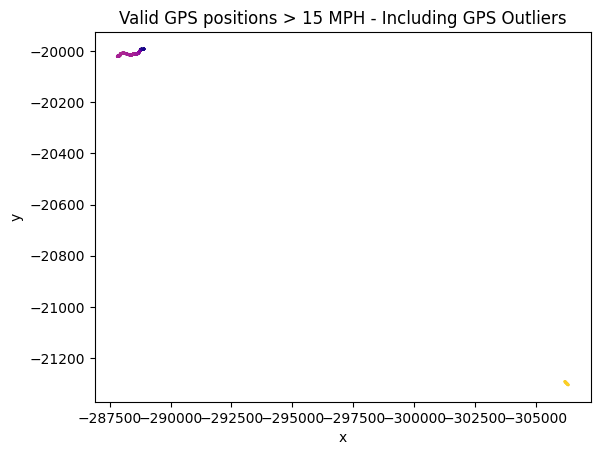

In [139]:
# longitudes = [float(pos['longitude'].split()[0]) for pos in positions]
# latitudes = [float(pos['latitude'].split()[0]) for pos in positions]

x = [pos['x'] for pos in positions]
y = [pos['y'] for pos in positions]

speeds = [pos['speed'] for pos in positions]

norm = plt.Normalize(min(speeds), max(speeds))
cmap = plt.cm.plasma


plt.scatter(x, y, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)

plt.xlabel('x')
plt.ylabel('y')

# flip axis to show the map in the correct orientation
plt.gca().invert_xaxis()
plt.title('Valid GPS positions > 15 MPH - Including GPS Outliers')
# show heat map of point concentration
plt.show()

# remove outliers

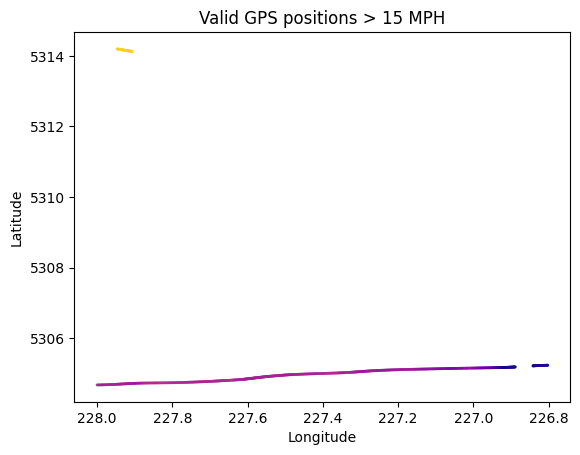

Median Longitude: 227.445695
Median Latitude: 5305.003455


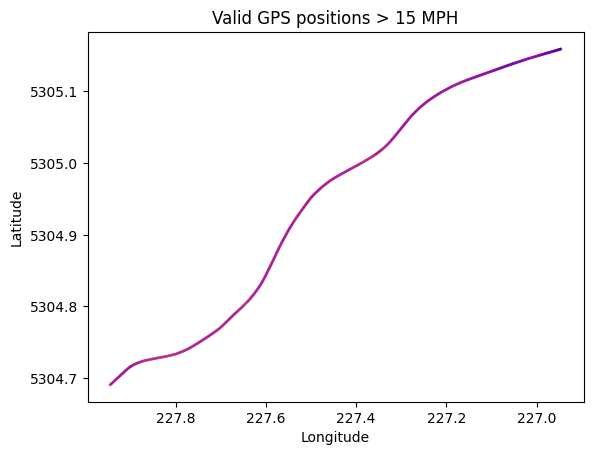

In [140]:
x = [float(pos['longitude'].split()[0]) for pos in positions]
y = [float(pos['latitude'].split()[0]) for pos in positions]
speeds = [pos['speed'] for pos in positions]

plt.scatter(x, y, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# flip axis to show the map in the correct orientation
plt.gca().invert_xaxis()
plt.title('Valid GPS positions > 15 MPH')
# show heat map of point concentration
plt.show()

median_longitude = np.median(x)
median_latitude = np.median(y)

print(f'Median Longitude: {median_longitude}')
print(f'Median Latitude: {median_latitude}')

# filter out the points that are not within GPGGA (
positions = [pos for pos in positions if abs(float(pos['longitude'].split()[0]) - median_longitude) < 0.5 and abs(float(pos['latitude'].split()[0]) - median_latitude) < 0.5]

x = [float(pos['longitude'].split()[0]) for pos in positions]
y = [float(pos['latitude'].split()[0]) for pos in positions]
speeds = [pos['speed'] for pos in positions]


plt.scatter(x, y, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# flip axis to show the map in the correct orientation
plt.gca().invert_xaxis()
plt.title('Valid GPS positions > 15 MPH')
# show heat map of point concentration
plt.show()

# Find bends

Found 1084 angles
[ 10.44874386   7.75707835  -1.36359404 -12.04832385 -24.22500777]


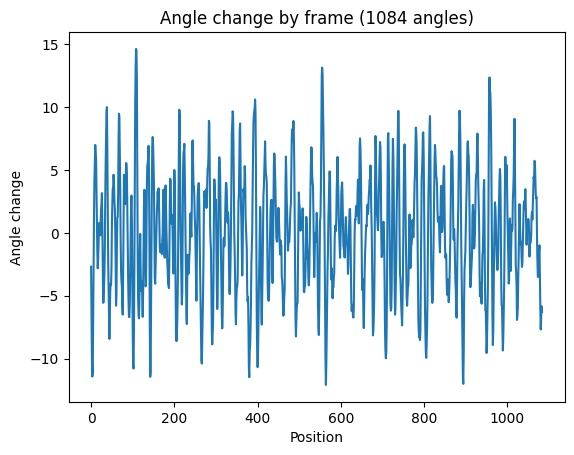

Found 241 bends
[ -9.9027011  -11.43070687 -11.10992219  -6.82321863   7.00112165
   6.35269033   7.51717005   9.48662387  10.01435126   6.90042547]
Found 12 bends after clustering


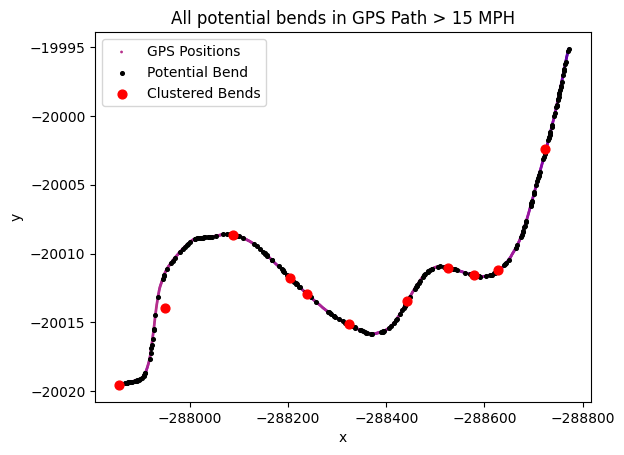

In [147]:
from sklearn.cluster import DBSCAN

x_pos = [pos['x'] for pos in positions]
y_pos = [pos['y'] for pos in positions]

diff_x = np.diff(x_pos)
diff_y = np.diff(y_pos)
vectors = np.vstack((diff_x, diff_y)).T

angles = np.arctan2(diff_x, diff_y)

angles = np.arctan2(np.sin(angles), np.cos(angles)) # normalize angles

angles = np.degrees(angles)

# smooth angles with gaussian filter
angles = np.convolve(angles, np.ones(3) / 3, mode='valid')
gaussian_kernel = np.exp(-np.linspace(-1, 1, 10)**2)

# zero first half of the kernel
zero = np.zeros_like(gaussian_kernel)
gaussian_kernel = np.concatenate([zero, gaussian_kernel])
gaussian_kernel /= gaussian_kernel.sum()
angles = np.convolve(angles, gaussian_kernel, mode='valid')

print(f"Found {len(angles)} angles")
print(angles[:5])
angles_derivative = np.gradient(angles)

plot_angles = angles_derivative
plt.title(f"Angle change by frame ({len(angles)} angles)")
plt.xlabel("Position")
plt.ylabel("Angle change")
plt.plot(plot_angles)
plt.show()

# angle change threshold
lower_threshold = 6  # degrees
# angle_diff = np.abs(np.diff(angles))
bends = np.where(np.abs(angles_derivative) > lower_threshold)[0]

print(f"Found {len(bends)} bends")
print(angles_derivative[bends][:10])

# cluster bends
bends_positions = np.array(list(zip(x_pos, y_pos)))[bends]

temp_store_bends = bends_positions.copy()


# bends = cluster.vq.kmeans(bends_positions, )[0]
# Apply DBSCAN clustering (automatic K)
if len(bends_positions) > 1:
    dbscan = DBSCAN(eps=10, min_samples=2, metric="euclidean")  # Adjust eps based on your GPS resolution
    labels = dbscan.fit_predict(bends_positions)
    
    # Get unique cluster centers
    unique_labels = set(labels)
    bends = np.array([bends_positions[labels == i].mean(axis=0) for i in unique_labels if i != -1])  # Ignore noise
else:
    bends = bends_positions  # If no clustering is needed, keep original bends

print(f"Found {len(bends)} bends after clustering")

# ignore last bend due to noisy data
bends = bends[:-1]

plt.scatter(
    x_pos,
    y_pos,
    c=[cmap(norm(float(s))) for s in speeds],
    s=1,
    label='GPS Positions'
)

plt.scatter(
    temp_store_bends[:, 0],
    temp_store_bends[:, 1],
    color='black',
    label='Potential Bend',
    s=7
)

if len(bends) > 0:
    plt.scatter(
        bends[:,0],
        bends[:,1],
        color='red',
        label='Clustered Bends',
        s=40
    )
else:
    plt.legend(["GPS Positions", "Potential Bend"])
    
plt.title("All potential bends in GPS Path > 15 MPH")
plt.ylabel("y")
plt.xlabel("x")
plt.gca().invert_xaxis()
# plt.legend(["GPS Positions", "Potential Bend", "Clustered Bends"])
plt.legend()

plt.savefig(os.path.join(output_folder, "bends.png"))
plt.show()

In [142]:
bends

array([[-287949.50966395,  -20013.93549376],
       [-288443.10571598,  -20013.42575541],
       [-288324.50241446,  -20015.11532954],
       [-288578.66092036,  -20011.58170378],
       [-288088.33059042,  -20008.67039567],
       [-288203.84708158,  -20011.75371804],
       [-288723.52375611,  -20002.39747636],
       [-288626.72503769,  -20011.21189846],
       [-288238.53942626,  -20012.94453227],
       [-287854.55130613,  -20019.53340234],
       [-288526.5070358 ,  -20011.05169354]])

In [143]:
cap = cv2.VideoCapture(file_path, cv2.CAP_FFMPEG)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate = cap.get(cv2.CAP_PROP_FPS)

print(f"Total frames: {total_frames}")

print(f"Frame rate: {frame_rate}")

Total frames: 5400
Frame rate: 29.97002997002997


In [144]:
def time_stamp_to_frame_number(time_stamp):
    diff = time_stamp_to_epoch(time_stamp) - STARTING_TIME
    total_time = END_TIME - STARTING_TIME
    if total_time <= 0:
        return 0
    
    return int((diff / total_time) * total_frames)

def get_closest_position_based_on_lat_lon(lat, lon):
    min_distance = float('inf')
    closest_position = None
    for position in positions:
        p_lat = float(position['y'])
        p_lon = float(position['x'])
        distance = (p_lat - lat)**2 + (p_lon - lon)**2
        if distance < min_distance:
            min_distance = distance
            closest_position = position
    return closest_position


def get_frame_number_based_on_bend_long_lat(bends):
    frame_numbers = []
    for bend in bends:
        closest_position = get_closest_position_based_on_lat_lon(bend[1], bend[0])
        frame_number = time_stamp_to_frame_number(closest_position['time'])
        # print(f"frame_number: {frame_number}")
        frame_numbers.append(frame_number)

    return frame_numbers

frame_numbers = get_frame_number_based_on_bend_long_lat(bends)

# frame_numbers = [int(frame_number*(frame_rate/10)) for frame_number in frame_numbers]

frame_numbers

[4786, 3398, 3777, 2971, 4345, 4068, 2316, 2824, 3984, 5246, 3113]

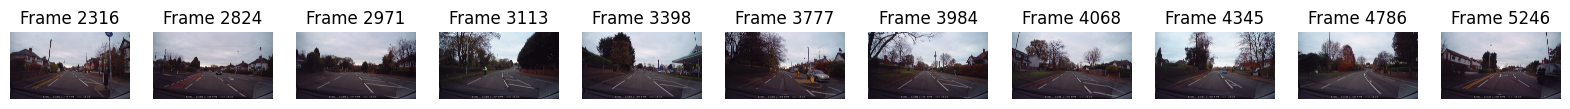

Total frames: 5400


In [145]:
frames = []

frame_numbers = sorted(frame_numbers)

for frame_number in frame_numbers:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        frames.append(frame)
    else:
        print(f"Warning: Could not read frame {frame_number}")
 
cap.release()

if frames:
    fig, axes = plt.subplots(1, len(frames), figsize=(20, 10))
    if len(frames) == 1:
        axes.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
        axes.axis('off')
        axes.set_title(f"Frame {frame_numbers[0]}")
    else:
        for i, frame in enumerate(frames):
            axes[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axes[i].axis('off')
            axes[i].set_title(f"Frame {frame_numbers[i]}")
    plt.show()
else:
    print("No frames to display")

print(f"Total frames: {total_frames}")

In [146]:
for i, frame in enumerate(frames):
    output_file = os.path.join(output_folder, f"bend_{i}.jpg")
    cv2.imwrite(output_file, frame)
